# Evolution with Opponent-Learning Awareness

In [4]:
import torch
import numpy as np
import copy
import time
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path

np.set_printoptions(precision=4)

SAV_DIR = Path("./figures")

## Games

In [5]:
def load_game(game_id: str):
    """
    Loads the requested game matrix.
    """

    game_id = game_id.lower()

    if game_id in ["sh", "stag hunt"]:
        """
        Easy Stag Hunt version (not used in the paper),
        The population intialized around the self-play fork.
        """

        a = 2  # stag stag
        b = 0.0  # stag hare
        c = 1.0
        d = 1.0

        A = torch.tensor([[a, b],
                         [c, d]], requires_grad=False)
    
    elif game_id in ["sh2",]:
        """
        Hard Stag Hunt version (used in the paper),
        The population intialized below the self-play fork.
        """

        a = 1.8  # stag stag
        b = 0.0  # stag hare
        c = 1.0
        d = 1.0

        A = torch.tensor([[a, b],
                         [c, d]], requires_grad=False)

    elif game_id in ["hd", "hawk dove"]:
        """
        Hawk-Dove environment used in the paper,
        The population intialized around the mixed Nash.
        """

        v = 2.0
        c = 4.0

        # W > T > L > X

        x = (v - c) / 2  # -1
        w = v  # 2
        l = 0.0
        t = v / 2  # 1

        A = torch.tensor([[x, w],
                          [l, t]], requires_grad=False)

    elif game_id in ["pd", "prisonners dilemma"]:

        # T > R > P > S 

        r = -1.0  # CC
        s = -3.0  # CD
        t = 0.0  # DC
        p = -2.0  # DD
        
        A = torch.tensor([[r, s],
                         [t, p]], requires_grad=False)

    elif game_id in ["opd", "optional prisonners dilemma"]:

        # T > R > L > P > S 

        r = -1.0  # CC
        s = -3.0  # CD
        t = 0.0  # DC
        p = -2.0  # DD
        l = - 1.5  # abstain
        
        A = torch.tensor([[r, s, l],
                          [t, p, l],
                          [l, l, l]], requires_grad=False)

    elif game_id in ["rps", "rock paper scissors"]:
        """
        Rock-Paper-Scissors environment used in the paper,
        The population intialized around the mixed Nash.
        """

        A = torch.tensor([[0.0, -1.0, 1.0],
                          [1.0, 0.0, -1.0],
                          [-1.0, 1.0, 0.0]], requires_grad=False)
    
    else:
        raise RuntimeError(f"invalid id: {game_id}")
    return A

## Evolutionary simulations

In [3]:
def shuffle_agents(population, nb_agent_pairs, device):
    idx = torch.randperm(nb_agent_pairs * 2).to(device)
    shuffled_population = population[idx]
    return shuffled_population, idx

### Matrix-based simulation (batched update)

In [6]:
def simulation(game_matrix,
               nb_agent_pairs=1,
               learning_rate=1.0,
               lola_learning_rate=1.0,
               nb_iterations=1000,
               lola_ratio=1.0,
               device=None,
               random_init=True,
               seed=None,
               verbose=False,
               timeout=None,
               self_play=False):
    
    t_start = time.time()
    
    if seed is not None:
        torch.manual_seed(seed)

    if device is None:
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"

    A = game_matrix.to(device)
    A_T = A.T
    
    second_order_learning_rate = learning_rate * lola_learning_rate
    
    nb_agents = 2 * nb_agent_pairs
    lola = lola_ratio > 0
    nb_lola_agents = int(lola_ratio * nb_agents)
    
    nb_actions = A.shape[0]

    history = []
    
    population = torch.zeros(size=(nb_agents, nb_actions)).to(device)
    if random_init:
        population = torch.nn.init.uniform_(population, -1, 1)
        if self_play:
            first_agent = population[0]
            population = torch.zeros(size=(nb_agents, nb_actions)).to(device)
            population = torch.add(population, first_agent)
    
    if verbose:
        print(f"Initial population:\n{population}\n---")

    history.append(copy.deepcopy(population.cpu()))
        
    with torch.no_grad():
        for _ in range(nb_iterations):

            if timeout is not None and time.time() - t_start > timeout:
                break

            shuffled_population, idx = shuffle_agents(population, nb_agent_pairs, device)
            agent_pairs = shuffled_population.view(nb_agent_pairs, 2, -1)
            policy_pairs = torch.nn.functional.softmax(agent_pairs, dim=2)
        
            # create a matrix to do operations for both agents in one go
            double_policy_pairs = torch.cat((policy_pairs, torch.index_select(policy_pairs, 1, torch.LongTensor([1,0]).to(device))), axis=0)
        
            # LOLA
        
            # naive updates:
        
            P_1 = double_policy_pairs[:, 0, :]
            P_2 = double_policy_pairs[:, 1, :]
            
            ones = torch.ones_like(P_1).to(device)
            I = torch.eye(nb_actions).to(device)
            X_1 = I - torch.einsum('bi,bj->bij', ones, P_1)
            Q_1 = torch.einsum('ik,bk->bi', A, P_2)
            U_1 = torch.einsum('bik,bk->bi', X_1, Q_1)
        
            naive_update = P_1 * U_1

            # print(f"naive update: {naive_update}")
                
            naive_update_theta_1 = naive_update[:nb_agent_pairs]
            naive_update_theta_2 = naive_update[nb_agent_pairs:]
                
            agent_pairs[:, 0, :] += naive_update_theta_1 * learning_rate
            agent_pairs[:, 1, :] += naive_update_theta_2 * learning_rate
    
            if lola:
                P_T = torch.einsum('bi,bj->bij', P_1, P_2)
                X_2 = I - torch.einsum('bi,bj->bij', ones, P_2)
                Q_2 = torch.einsum('ik,bk->bi', A, P_1)
                U_21 = torch.einsum('bik,bk->bi', X_2, Q_2)
                S_1 = P_2 * U_21
                M_1 = torch.einsum('ij,bkj->bik', A, X_2)
                N_1 = torch.einsum('bij,bjk->bik', X_1, M_1)
                O_1 = P_T * N_1
                R_1 = torch.einsum('bik,bk->bi', O_1, S_1)
    
                Q_2_T = torch.einsum('ik,bk->bi', A_T, P_1)
                U_21_T = torch.einsum('bik,bk->bi', X_2, Q_2_T)
                S_2 = P_2 * U_21_T
    
                M_2 = torch.einsum('ij,bkj->bik', A_T, X_2)
                N_2 = torch.einsum('bij,bjk->bik', X_1, M_2)
                O_2 = P_T * N_2
                R_2 = torch.einsum('bik,bk->bi', O_2, S_2)
    
                mask = (idx < nb_lola_agents).unsqueeze(1).to(device)
                lola_update = (R_1 + R_2) * mask
    
                lola_update_theta_1 = lola_update[:nb_agent_pairs]
                lola_update_theta_2 = lola_update[nb_agent_pairs:]
                
                agent_pairs[:, 0, :] += lola_update_theta_1 * second_order_learning_rate
                agent_pairs[:, 1, :] += lola_update_theta_2 * second_order_learning_rate
    
            shuffled_population = agent_pairs.view(nb_agents, nb_actions)
            population[idx] = shuffled_population

            history.append(copy.deepcopy(population.cpu()))
        
    if verbose:
        print(f"Final population:\n{population}\n---")
    
    return history

### Gradient-based simulation (batched update)

In [7]:
def slow_simulation(game_matrix,
               nb_agent_pairs=1,
               learning_rate=1.0,
               lola_learning_rate=1.0,
               nb_iterations=1000,
               lola_ratio=1.0,
               device=None,
               random_init=True,
               seed=None,
               verbose=False,
               timeout=None,
               self_play=False):
    """
    Simulates a population of LOLA and naive learning agents.
    Performs 2nd order backpropagation with pytorch.

    CAUTION: These computations use gradient summation tricks that are valid only for evolutionary simulations of pairwise agents.
    """

    t_start = time.time()

    if seed is not None:
        torch.manual_seed(seed)

    if device is None:
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"
    
    with torch.no_grad():
        A = game_matrix.to(device)
        A_T = A.T
        
        second_order_learning_rate = learning_rate * lola_learning_rate
        
        nb_agents = 2 * nb_agent_pairs
        lola = lola_ratio > 0
        nb_lola_agents = int(lola_ratio * nb_agents)
        
        nb_actions = A.shape[0]
        output_size = nb_actions

        history = []
        
        population = torch.zeros(size=(nb_agents, nb_actions)).to(device)

        if random_init:
            population = torch.nn.init.uniform_(population, -1, 1)
            if self_play:
                first_agent = population[0]
                population = torch.zeros(size=(nb_agents, nb_actions)).to(device)
                population = torch.add(population, first_agent)

        history.append(copy.deepcopy(population.cpu().detach()))
    
    if verbose:
        print(f"Initial population:\n{population}\n---")

    # Here, we cannot update the population directly
    population.requires_grad = False

    for _ in range(nb_iterations):

        if timeout is not None and time.time() - t_start > timeout:
            break

        # Shuffle agents
        shuffled_population, idx = shuffle_agents(population, nb_agent_pairs, device)
        
        if verbose:
            print(f"shuffled_population : {shuffled_population.shape}:\n{shuffled_population}")

        agent_pairs = shuffled_population.view(nb_agent_pairs, 2, -1)

        # print(f"agent_pairs : {agent_pairs.shape}:\n{agent_pairs}")

        double_agent_pairs = torch.cat((agent_pairs, torch.index_select(agent_pairs, 1, torch.LongTensor([1,0]).to(device))), axis=0)

        # print(f"double_agent_pairs : {double_agent_pairs.shape}:\n{double_agent_pairs}")

        # Generate leaf thetas
        T_1 = double_agent_pairs[:, 0, :]
        T_2 = double_agent_pairs[:, 1, :]
        T_1.requires_grad = True
        T_2.requires_grad = True
        assert T_1.is_leaf
        assert T_2.is_leaf

        init_double_agent_pairs = torch.stack((T_1, T_2), dim=1)

        # print(f"init_double_agent_pairs : {init_double_agent_pairs.shape}:\n{init_double_agent_pairs}")

        double_policy_pairs = torch.nn.functional.softmax(init_double_agent_pairs, dim=2)

        # print(f"double_policy_pairs : {double_policy_pairs.shape}:\n{double_policy_pairs}")

        # Probabilities for ego agent:
        P_1 = double_policy_pairs[:, 0, :]

        # Probabilities for other agent:
        P_2 = double_policy_pairs[:, 1, :]  # .detach()  # detach opponents

        # Action-values for ego agent:
        Q_1 = torch.einsum('ik,bk->bi', A, P_2)

        # Policy value for ego agent:
        V_1 = torch.einsum('bk,bk->b', P_1, Q_1)

        # Compute naive update
        SV1 = torch.sum(V_1)
        D1V1 = torch.autograd.grad(SV1, T_1, create_graph=True)[0]

        update = D1V1 * learning_rate

        # print(f"T_1 : {T_1.shape}:\n{T_1}")

        # print(f"D1V1 : {D1V1.shape}:\n{D1V1}")

        if lola:
            # Compute the additional required quantities
            Q_2 = torch.einsum('ik,bk->bi', A, P_1)
            V_2 = torch.einsum('bk,bk->b', P_2, Q_2)
            SV2 = torch.sum(V_2)
            
            # Compute 1st-order gradients
            D2V1 = torch.autograd.grad(SV1, T_2, create_graph=True)[0]
            # D1V2 = torch.autograd.grad(SV2, T_1, create_graph=True)[0]
            D2V2 = torch.autograd.grad(SV2, T_2, create_graph=True)[0]

            lola_value = torch.einsum('ba,ba->b', D2V2, D2V1)

            # print(f"lola_value : {lola_value.shape}:\n{lola_value}")

            lola_value_sum = torch.sum(lola_value)

            lola_grad = torch.autograd.grad(lola_value_sum, T_1, create_graph=True)[0]

            lola_update = lola_grad * second_order_learning_rate
            update += lola_update

        with torch.no_grad():
            T_1 += update
            agent_pairs[:, 0, :] = T_1[:nb_agent_pairs]
            agent_pairs[:, 1, :] = T_1[nb_agent_pairs:]

            shuffled_population = agent_pairs.view(nb_agents, nb_actions)
            population[idx] = shuffled_population

        history.append(copy.deepcopy(population.cpu().detach()))
    
    if verbose:
        print(f"Final population:\n{population}\n---")
    
    return history

### Gradient-based simulation (iterative update)

In [8]:
import random

def naive_simulation(game_matrix,
               nb_agent_pairs=1,
               learning_rate=1.0,
               lola_learning_rate=1.0,
               nb_iterations=1000,
               lola_ratio=1.0,
               device=None,
               random_init=True,
               seed=None,
               verbose=False,
               timeout=None,
               self_play=False):
    """
    Simulates a population of LOLA and naive learning agents.
    Performs 2nd order backpropagation with pytorch.

    This version computes updates in the usual iterative, non-batched version of non-evolutionary MARL environments.
    The point of this function is mostly to demonstrate the massive gain of computational performance that we achieve from batching pairwise evolutionary simulations.
    """

    t_start = time.time()

    if seed is not None:
        torch.manual_seed(seed)

    if device is None:
        if torch.cuda.is_available():
            device = "cuda:0"
        else:
            device = "cpu"
    
    with torch.no_grad():
        A = game_matrix.to(device)
        A_T = A.T
        
        second_order_learning_rate = learning_rate * lola_learning_rate
        
        nb_agents = 2 * nb_agent_pairs
        lola = lola_ratio > 0
        nb_lola_agents = int(lola_ratio * nb_agents)
        
        nb_actions = A.shape[0]
        output_size = nb_actions

        history = []
        
        population = torch.zeros(size=(nb_agents, nb_actions)).to(device)

        if random_init:
            population = torch.nn.init.uniform_(population, -1, 1)
            if self_play:
                first_agent = population[0]
                population = torch.zeros(size=(nb_agents, nb_actions)).to(device)
                population = torch.add(population, first_agent)

        history.append(copy.deepcopy(population.cpu().detach()))
    
    if verbose:
        print(f"Initial population:\n{population}\n---")

    population.requires_grad = False

    for _ in range(nb_iterations):

        if timeout is not None and time.time() - t_start > timeout:
            break

        # Shuffle agents

        shuffled_population, idx = shuffle_agents(population, nb_agent_pairs, device)

        if verbose:
            print(f"shuffled_population : {shuffled_population.shape}:\n{shuffled_population}")

        agents_population = [agent for agent in shuffled_population]
        
        # Sequential updates:
        for i in range(len(agents_population)):
            opponent_i = i + 1 - 2 * (i % 2)
            T_1 = agents_population[i]
            T_2 = agents_population[opponent_i]
            T_1.requires_grad = True
            T_2.requires_grad = True
            assert T_1.is_leaf
            assert T_2.is_leaf

            P_1 = torch.nn.functional.softmax(T_1, dim=0)
            P_2 = torch.nn.functional.softmax(T_2, dim=0)

            # Action-values for ego agent:
            Q_1 = torch.einsum('ik,k->i', A, P_2)

            # Policy value for ego agent:
            V_1 = torch.dot(P_1, Q_1)

            # Compute naive update
            D1V1 = torch.autograd.grad(V_1, T_1, create_graph=True)[0]
            update = D1V1 * learning_rate

            if lola:
                # Compute the additional required quantities
                Q_2 = torch.einsum('ik,k->i', A, P_1)
                V_2 = torch.dot(P_2, Q_2)
                
                # Compute 1st-order gradients
                D2V1 = torch.autograd.grad(V_1, T_2, create_graph=True)[0]
                D2V2 = torch.autograd.grad(V_2, T_2, create_graph=True)[0]

                lola_value = torch.dot(D2V2, D2V1)

                # print(f"lola_value : {lola_value.shape}:\n{lola_value}")

                lola_grad = torch.autograd.grad(lola_value, T_1, create_graph=True)[0]

                lola_update = lola_grad * second_order_learning_rate
                update += lola_update

            with torch.no_grad():
                T_1 += update
                agents_population[i] = T_1
        
        with torch.no_grad():
            for i in range(len(agents_population)):
                shuffled_population[i] = agents_population[i]
            
            population[idx] = shuffled_population

        history.append(copy.deepcopy(population.cpu().detach()))
    
    if verbose:
        print(f"Final population:\n{population}\n---")
    
    return history

## Experiments

In [9]:
def experiment(sim_fn,
               game,
               nb_agent_pairs=100,
               learning_rate=1.0,
               lola_learning_rate=1.0,
               nb_iterations=1000,
               lola_ratio=1.0,
               device="cpu",
               random_init=True,
               seed=None,
               repeatitions=1,
               timeout=100.0,
               self_play=False):

    A = load_game(game)

    hist = []
    
    for _ in range(repeatitions):
        hist = sim_fn(A,
                      nb_agent_pairs=nb_agent_pairs,
                      learning_rate=learning_rate,
                      lola_learning_rate = lola_learning_rate,
                      nb_iterations = nb_iterations,
                      lola_ratio=lola_ratio,
                      device=device,
                      seed=seed,
                      random_init=random_init,
                      timeout=timeout,
                      self_play=self_play)
        if len(hist) != nb_iterations + 1:
            hist = []
    
    return hist

### Timing experiments

In [11]:
record_hist = False

device_list = ["cpu",
               "cuda:0"]

game_list = ["rps"]

nb_pairs_list = [1,
                 100,
                 1000,
                 10000]

seed_list = [0,]

lola_ratio_list = [1.0,]

sim_fn_list = [naive_simulation,
               slow_simulation,
               simulation]

random_init_list = [True,]

repeatitions = 1
learning_rate = 1.0
lola_learning_rate = 1.0
nb_iterations = 1000
timeout=200.0

all_res = []

for device in device_list:
    for game in game_list:
        for nb_agent_pairs in nb_pairs_list:
            for seed in seed_list:
                for lola_ratio in lola_ratio_list:
                    for sim_fn in sim_fn_list:

                        if sim_fn == naive_simulation and nb_agent_pairs > 100:
                            continue

                        for random_init in random_init_list:
                            t_start = time.time()
                            res = experiment(sim_fn,
                                             game,
                                             nb_agent_pairs=nb_agent_pairs,
                                             learning_rate=learning_rate,
                                             lola_learning_rate=lola_learning_rate,
                                             nb_iterations=nb_iterations,
                                             lola_ratio=lola_ratio,
                                             device=device,
                                             random_init=True,
                                             seed=seed,
                                             repeatitions=repeatitions,
                                             timeout=timeout)
                            if len(res) > 0:
                                duration = (time.time() - t_start) / repeatitions
                            else:
                                duration = None
                            
                            dres = {"device": device,
                                    "game": game,
                                    "nb_agent_pairs": nb_agent_pairs,
                                    "seed": seed,
                                    "sim_fn": sim_fn.__name__,
                                    "random_init": random_init,
                                    "repeatitions": repeatitions,
                                    "learning_rate": learning_rate,
                                    "lola_learning_rate": lola_learning_rate,
                                    "nb_iterations": nb_iterations,
                                    "timeout": timeout,
                                    "duration": duration,
                                    "hist": res if record_hist else None}
                            
                            lh = len(dres['hist']) if record_hist else None
                            print(f"Finished experiment:\n{dres['device']} {dres['game']}, {dres['nb_agent_pairs']} pairs, {dres['sim_fn']} : {dres['duration']} s, hist: {lh}")
                            all_res.append(dres)

with open("results_timing.pkl", "wb") as f:
    pkl.dump(all_res, f)

Finished experiment:
cpu rps, 1 pairs, naive_simulation : 0.44909191131591797 s, hist: None
Finished experiment:
cpu rps, 1 pairs, slow_simulation : 2.8410117626190186 s, hist: None
Finished experiment:
cpu rps, 1 pairs, simulation : 0.4475235939025879 s, hist: None
Finished experiment:
cpu rps, 100 pairs, naive_simulation : 37.13488721847534 s, hist: None
Finished experiment:
cpu rps, 100 pairs, slow_simulation : 3.1590192317962646 s, hist: None
Finished experiment:
cpu rps, 100 pairs, simulation : 1.037806749343872 s, hist: None
Finished experiment:
cpu rps, 1000 pairs, slow_simulation : 4.288691759109497 s, hist: None
Finished experiment:
cpu rps, 1000 pairs, simulation : 1.8847193717956543 s, hist: None
Finished experiment:
cpu rps, 10000 pairs, slow_simulation : 10.657302379608154 s, hist: None
Finished experiment:
cpu rps, 10000 pairs, simulation : 3.156073570251465 s, hist: None
Finished experiment:
cuda:0 rps, 1 pairs, naive_simulation : 1.2363989353179932 s, hist: None
Finishe

In [13]:
with open("results_timing.pkl", "rb") as f:
    all_res = pkl.load(f)

In [26]:
def to_label(sim_fn):
    if "naive" in sim_fn:
        return "autograd iterative LOLA"
    elif "slow" in sim_fn:
        return "autograd batched LOLA"
    else:
        return "matrix batched LOLA"

def plot(all_res, device, game, lola_ratio, ylim=None, dpi=100, title=None):

    plt.figure(dpi=dpi)
    
    sim_fn_list = []
    nb_agent_pairs_list = []
    seed_list = []
    
    to_plot = []

    for res in all_res:
        if res["device"] == device and res["game"] == game:
            to_plot.append(res)
            if res["sim_fn"] not in sim_fn_list:
                sim_fn_list.append(res["sim_fn"])
            if res["nb_agent_pairs"] not in nb_agent_pairs_list:
                nb_agent_pairs_list.append(res["nb_agent_pairs"])
            if res["seed"] not in seed_list:
                seed_list.append(res["seed"])
    
    nb_agent_pairs_list.sort()
    nb_agent_pairs_list = np.array(nb_agent_pairs_list)

    for sim_fn in sim_fn_list:
        for seed in seed_list:
            line = []
            for nb_agent_pairs in nb_agent_pairs_list:
                for res in to_plot:
                    if res["sim_fn"] == sim_fn and res["seed"] == seed and res["nb_agent_pairs"] == nb_agent_pairs:
                        line.append(res["duration"] / res["nb_iterations"])
            
            plt.plot(nb_agent_pairs_list[:len(line)] * 2, line, label=f"{to_label(sim_fn)}", linewidth=3)
    
    if ylim is not None:
        plt.ylim(ylim)
    plt.xlabel("population size")
    plt.ylabel("population update duration (s)")
    # if title:
    #     plt.title(title)
    # else:
    #     plt.title(f"Game: {game}, device: {device}")
    plt.title(f" ")
    plt.legend()
    # plt.tight_layout()
    plt.savefig(SAV_DIR / f"{title}.png", bbox_inches='tight')
    plt.show()

In [27]:
matplotlib.rcParams.update({'font.size': 20})

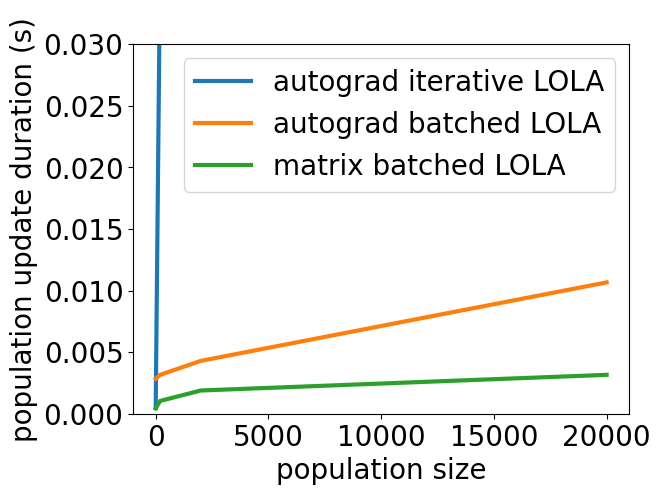

In [28]:
plot(all_res,
     device="cpu",
     game="rps",
     lola_ratio=1.0,
     ylim=(0, 0.03),
     dpi=100,
     title=f"CPU performance")

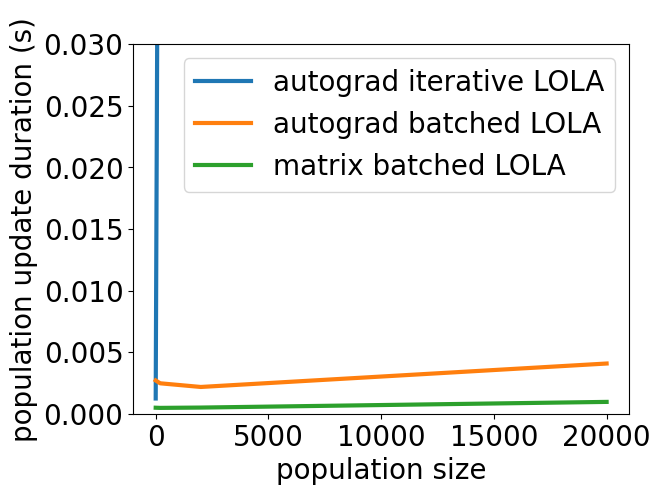

In [29]:
plot(all_res,
     device="cuda:0",
     game="rps",
     lola_ratio=1.0,
     ylim=(0, 0.03),
     dpi=100,
     title=f"GPU performance")

## Population experiments

In [31]:
def plot_2d_experiment(action_1, action_2, hist, nb_color_bins=100, title=None, dpi=200, sav_title=None, bin_above=4, lola_ratio=None):
    with torch.no_grad():
        initial_population = hist[0]
        assert initial_population.shape[1] == 2  # 2D
        plt.figure(dpi=dpi)
        if initial_population.shape[0] > bin_above:
            color_bins = []
            for population in hist:
                policies = torch.nn.functional.softmax(population, dim=1)
                bins = torch.histc(policies[:, 0], nb_color_bins, min=0, max=1)  # 2D softmax: we only need to look at the first proba
                sum = torch.sum(bins)
                bins = bins / sum  # normalize
                color_bins.append(bins.numpy())
            image = np.array(color_bins).T
            # image = (image ** 0.4 + 2*(image ** 0.1)) / 3  # custom color mapping
            image = image ** 0.15
            plt.pcolormesh(image, cmap="Blues")  # Greys
            plt.tick_params(left = False)
            plt.yticks(ticks=[0, nb_color_bins], labels=[action_2, action_1])
        else:  # simple plot
            params = torch.tensor(np.array(hist))
            policies = torch.nn.functional.softmax(params, dim=2)
            print(policies.shape)
            nb_curves = policies.shape[1]
            plt.tick_params(left = False)
            plt.ylim((0,1))
            plt.yticks(ticks=[0, 1], labels=[action_2, action_1])
            for curve_idx in range(nb_curves):
                plt.plot(policies[:, curve_idx, 0])
        plt.xlabel("evolution step")
        # if title:
        #     plt.title(title)
        st = sav_title if sav_title else f"{title}"
        plt.savefig(SAV_DIR / f"{st}.png", bbox_inches='tight')
        plt.show()

def plot_2d_experiment_bicolor(action_1, action_2, hist, lola_ratio, nb_color_bins=100, title=None, dpi=200, sav_title=None, bin_above=4):
    print(lola_ratio)
    with torch.no_grad():
        initial_population = hist[0]
        assert initial_population.shape[1] == 2  # 2D

        pop_size = initial_population.shape[0]
        lola_size = int(pop_size * lola_ratio)

        plt.figure(dpi=dpi)
        if initial_population.shape[0] > bin_above:
            color_bins = []
            for population in hist:
                policies = torch.nn.functional.softmax(population, dim=1)
                policies_lola = policies[:lola_size]
                policies_pg = policies[lola_size:]
                bins_lola = torch.histc(policies_lola[:, 0], nb_color_bins, min=0, max=1)  # 2D softmax: we only need to look at the first proba
                bins_pg = torch.histc(policies_pg[:, 0], nb_color_bins, min=0, max=1)
                sum_lola = torch.sum(bins_lola)
                sum_pg = torch.sum(bins_pg)
                total = sum_lola + sum_pg
                bins_lola = bins_lola / total  # normalize
                bins_pg = bins_pg / total
                color_bins.append(bins_pg.numpy())
            image = np.array(color_bins).T
            # image = (image ** 0.4 + 2*(image ** 0.1)) / 3  # custom color mapping
            # image = image ** 0.15
            plt.pcolormesh(image, cmap="Blues")  # Greys
            plt.tick_params(left = False)
            plt.yticks(ticks=[0, nb_color_bins], labels=[action_2, action_1])
        plt.xlabel("evolution step")
        # if title:
        #     plt.title(title)
        st = sav_title if sav_title else f"{title}"
        plt.savefig(SAV_DIR / f"{st}.png", bbox_inches='tight')
        plt.show()

In [32]:
def plot_2d_experiments_self_play(action_1, action_2, all_hist, title=None, dpi=200, sav_title=None):
    with torch.no_grad():
        cmap = matplotlib.colormaps['plasma']
        plt.figure(dpi=dpi)
        for hist in all_hist:
            initial_population = hist[0]
            assert initial_population.shape[1] == 2  # 2D
            params = torch.tensor(np.array(hist))
            policies = torch.nn.functional.softmax(params, dim=2)
            # plt.tick_params(left = False)
            plt.ylim((0,1))
            plt.yticks(ticks=[0, 0.5, 1], labels=[action_2, "", action_1])
            # plot first curve only
            plt.plot(policies[:, 0, 0], c=cmap(policies[0, 0, 0]))
        plt.xlabel("learning step")
        # if title:
        #     plt.title(title)
        st = sav_title if sav_title else f"{title}"
        plt.savefig(SAV_DIR / f"{st}.png", bbox_inches='tight')
        plt.show()

### Stag hunt easy

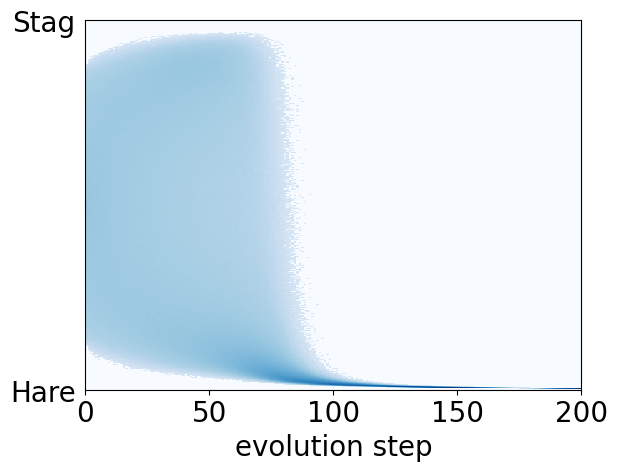

In [33]:
game = "sh"
game_str = "Stag hunt"
lola_ratio = 0.0
action_1 = "Stag"
action_2 = "Hare"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 1
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

plot_2d_experiment(action_1,
                   action_2,
                   res[:200],
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

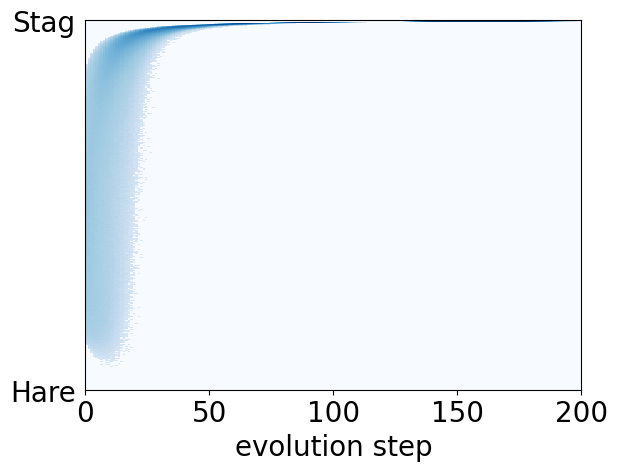

In [34]:
game = "sh"
game_str = "Stag hunt"
lola_ratio = 1.0
action_1 = "Stag"
action_2 = "Hare"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

plot_2d_experiment(action_1,
                   action_2,
                   res[:200],
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

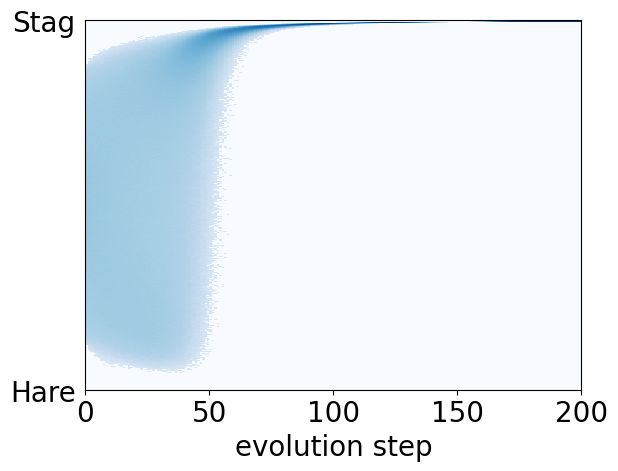

In [35]:
game = "sh"
game_str = "Stag hunt"
lola_ratio = 0.01
action_1 = "Stag"
action_2 = "Hare"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

plot_2d_experiment(action_1,
                   action_2,
                   res[:200],
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

## Stag hunt harder

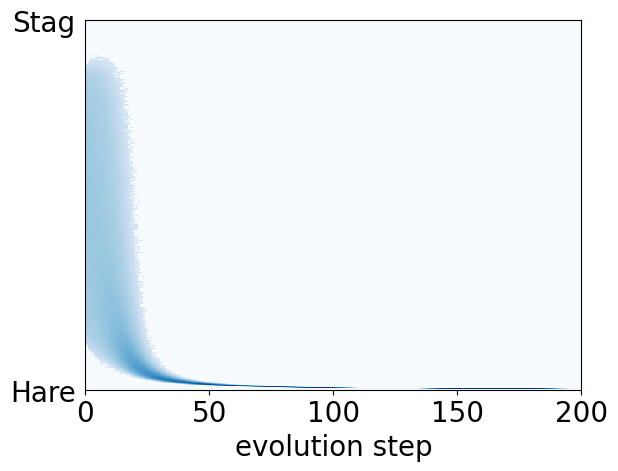

In [36]:
game = "sh2"
game_str = "Stag hunt hard"
lola_ratio = 0.0
action_1 = "Stag"
action_2 = "Hare"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

plot_2d_experiment(action_1,
                   action_2,
                   res[:200],
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

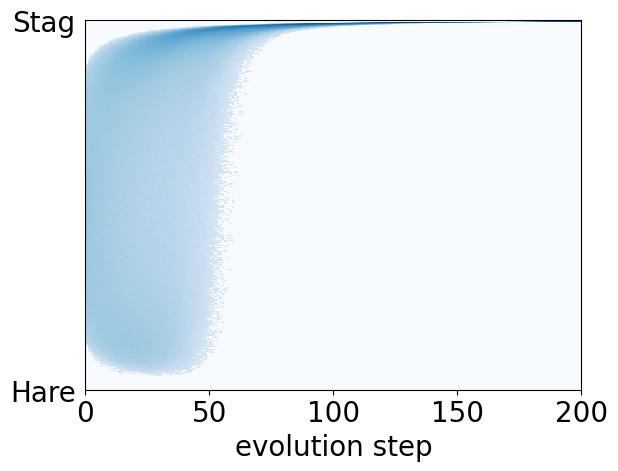

In [37]:
game = "sh2"
game_str = "Stag hunt hard"
lola_ratio = 1.0
action_1 = "Stag"
action_2 = "Hare"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

plot_2d_experiment(action_1,
                   action_2,
                   res[:200],
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

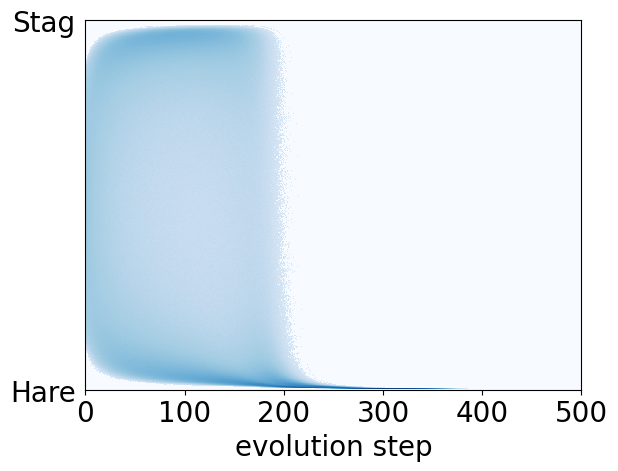

In [38]:
game = "sh2"
game_str = "Stag hunt hard"
lola_ratio = 0.85
action_1 = "Stag"
action_2 = "Hare"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

plot_2d_experiment(action_1,
                   action_2,
                   res[:500],
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

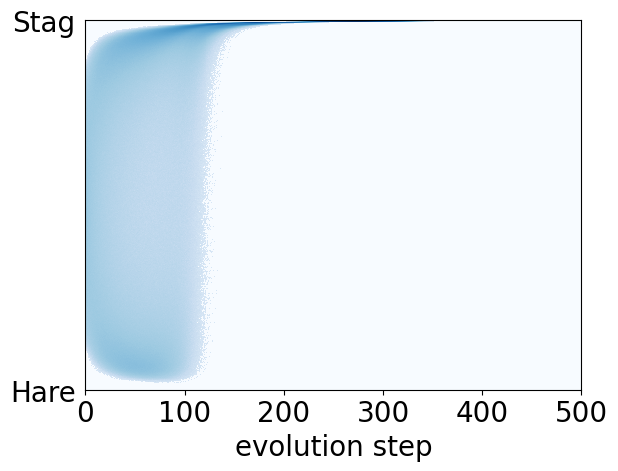

In [39]:
game = "sh2"
game_str = "Stag hunt hard"
lola_ratio = 0.86
action_1 = "Stag"
action_2 = "Hare"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

plot_2d_experiment(action_1,
                   action_2,
                   res[:500],
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

In [40]:
# Self-Play from random

game = "sh2"
game_str = "Stag hunt hard"
lola_ratio = 1
action_1 = "Stag"
action_2 = "Hare"

device = "cuda:0"
nb_agent_pairs = 1
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

final_policies_list = []
all_hist = []

for seed in range(1000):
    res = experiment(sim_fn,
                    game,
                    nb_agent_pairs=nb_agent_pairs,
                    learning_rate=learning_rate,
                    lola_learning_rate=lola_learning_rate,
                    nb_iterations=nb_iterations,
                    lola_ratio=lola_ratio,
                    device=device,
                    random_init=True,
                    seed=seed,
                    repeatitions=repeatitions,
                    timeout=timeout,
                    self_play=True)
    final_policies_list.append(res[-1])
    all_hist.append(res[:100])
# manual count:
count_hh = 0
count_ss = 0
count_sh = 0
count_other = 0
for final_params in final_policies_list:
    stags = 0
    hares = 0
    for params in final_params:
        policy = torch.nn.functional.softmax(params, dim=0)
        if policy[0] > 0.99:
            stags += 1
        elif policy[1] > 0.99:
            hares += 1
    nb_agents = final_params.shape[0]
    if stags == nb_agents:
        count_ss += 1
    elif hares == nb_agents:
        count_hh += 1
    elif stags == hares:
        count_sh += 1
    else:
        count_other +=1

count_total = count_hh + count_ss + count_sh + count_other

title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)"
print(title)
print(f"SS: {count_ss / count_total}, HH: {count_hh / count_total}, SH: {count_sh / count_total}, other: {count_other / count_total} (total: {count_total})")

Stag hunt hard - 2 agents (100% LOLA)
SS: 0.567, HH: 0.433, SH: 0.0, other: 0.0 (total: 1000)


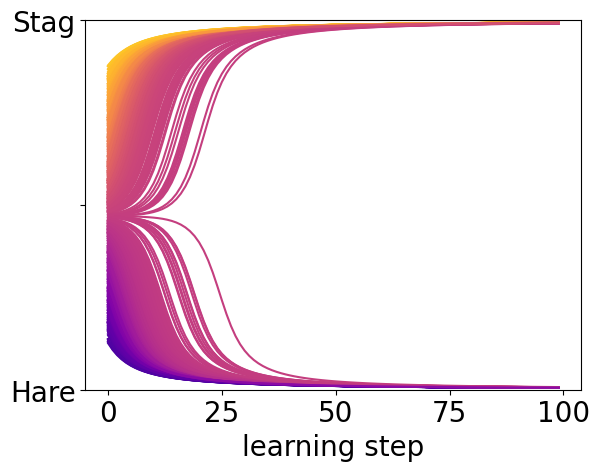

In [41]:
plot_2d_experiments_self_play(action_1,
                   action_2,
                   all_hist,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} self-play agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

In [42]:
# Self-Play from random

game = "sh2"
game_str = "Stag hunt hard"
lola_ratio = 0
action_1 = "Stag"
action_2 = "Hare"

device = "cuda:0"
nb_agent_pairs = 1
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

final_policies_list = []
all_hist = []

for seed in range(1000):
    res = experiment(sim_fn,
                    game,
                    nb_agent_pairs=nb_agent_pairs,
                    learning_rate=learning_rate,
                    lola_learning_rate=lola_learning_rate,
                    nb_iterations=nb_iterations,
                    lola_ratio=lola_ratio,
                    device=device,
                    random_init=True,
                    seed=seed,
                    repeatitions=repeatitions,
                    timeout=timeout,
                    self_play=True)
    final_policies_list.append(res[-1])
    all_hist.append(res[:100])
# manual count:
count_hh = 0
count_ss = 0
count_sh = 0
count_other = 0
for final_params in final_policies_list:
    stags = 0
    hares = 0
    for params in final_params:
        policy = torch.nn.functional.softmax(params, dim=0)
        if policy[0] > 0.99:
            stags += 1
        elif policy[1] > 0.99:
            hares += 1
    nb_agents = final_params.shape[0]
    if stags == nb_agents:
        count_ss += 1
    elif hares == nb_agents:
        count_hh += 1
    elif stags == hares:
        count_sh += 1
    else:
        count_other +=1

count_total = count_hh + count_ss + count_sh + count_other

title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)"
print(title)
print(f"SS: {count_ss / count_total}, HH: {count_hh / count_total}, SH: {count_sh / count_total}, other: {count_other / count_total} (total: {count_total})")

Stag hunt hard - 2 agents (0% LOLA)
SS: 0.407, HH: 0.593, SH: 0.0, other: 0.0 (total: 1000)


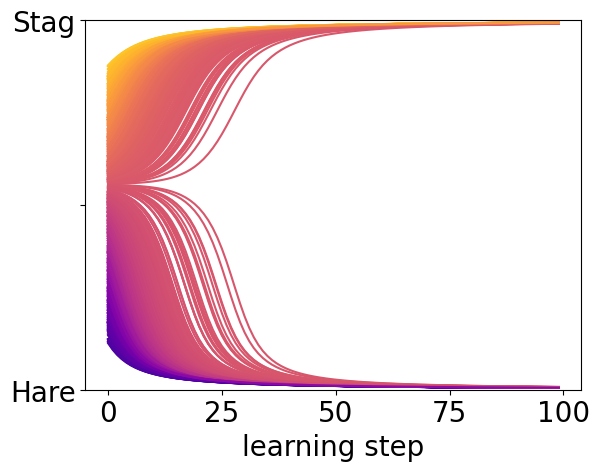

In [43]:
plot_2d_experiments_self_play(action_1,
                   action_2,
                   all_hist,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} self-play agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

## Hawk dove

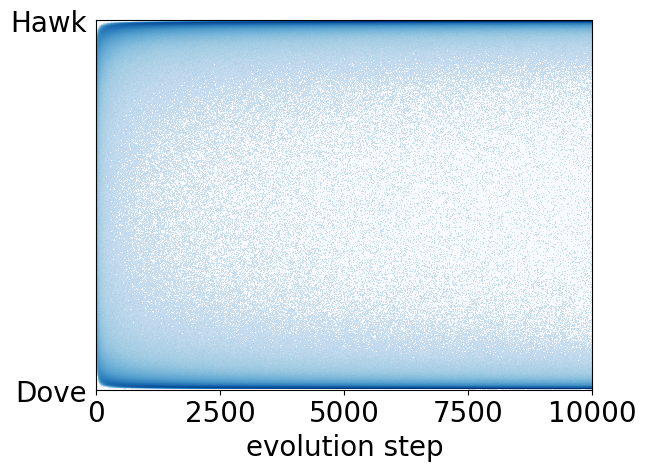

In [44]:
game = "hd"
game_str = "Hawk Dove"
lola_ratio = 1.0
action_1 = "Hawk"
action_2 = "Dove"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 10000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

plot_2d_experiment(action_1,
                   action_2,
                   res,
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

In [45]:
print(f"final average policy for LOLA ratio {lola_ratio}: {torch.mean(torch.nn.functional.softmax(res[-1], dim=1), dim=0)}")

final average policy for LOLA ratio 1.0: tensor([0.5003, 0.4997])


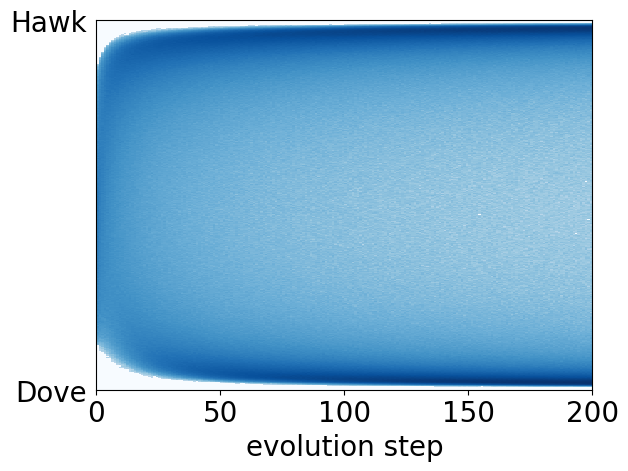

In [46]:
plot_2d_experiment(action_1,
                   action_2,
                   res[:200],
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   sav_title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA) (zoomed)",
                   dpi=100)

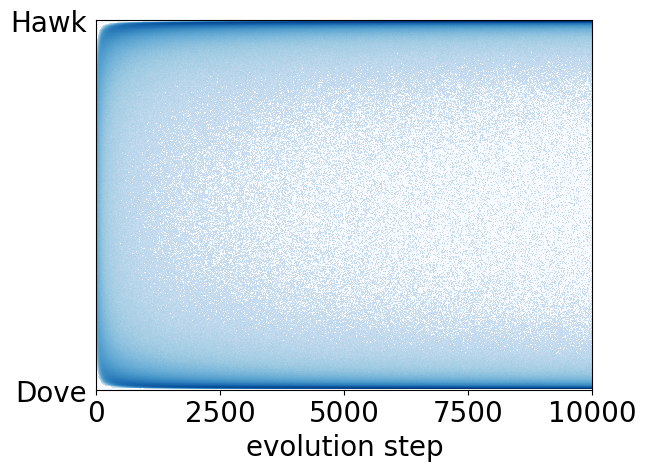

In [47]:
game = "hd"
game_str = "Hawk Dove"
lola_ratio = 0.0
action_1 = "Hawk"
action_2 = "Dove"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 10000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

plot_2d_experiment(action_1,
                   action_2,
                   res,
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

In [48]:
print(f"final average policy for LOLA ratio {lola_ratio}: {torch.mean(torch.nn.functional.softmax(res[-1], dim=1), dim=0)}")

final average policy for LOLA ratio 0.0: tensor([0.5001, 0.4999])


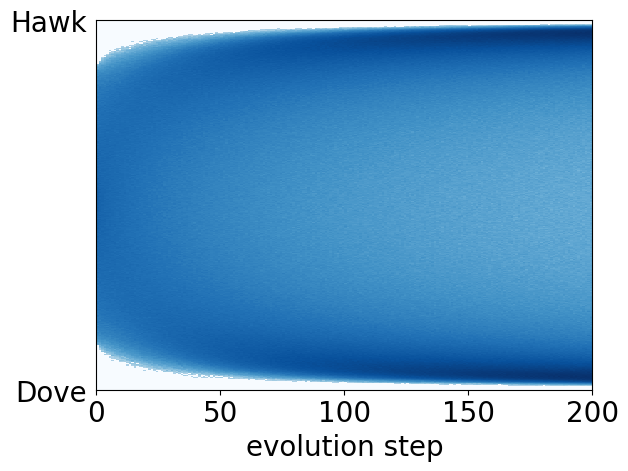

In [49]:
plot_2d_experiment(action_1,
                   action_2,
                   res[:200],
                   nb_color_bins=1000,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                   sav_title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA) (zoomed)",
                   dpi=100)

In [90]:
# Self-Play from random

game = "hd"
game_str = "Hawk Dove"
lola_ratio = 1.0
action_1 = "Hawk"
action_2 = "Dove"

device = "cuda:0"
nb_agent_pairs = 1
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

final_policies_list = []
all_hist = []

for seed in range(100):
    res = experiment(sim_fn,
                    game,
                    nb_agent_pairs=nb_agent_pairs,
                    learning_rate=learning_rate,
                    lola_learning_rate=lola_learning_rate,
                    nb_iterations=nb_iterations,
                    lola_ratio=lola_ratio,
                    device=device,
                    random_init=True,
                    seed=seed,
                    repeatitions=repeatitions,
                    timeout=timeout,
                    self_play=True)
    final_policies_list.append(res[-1])
    all_hist.append(res[:100])
# manual count:
count_hh = 0
count_ss = 0
count_sh = 0
count_other = 0
final_policies = []
for final_params in final_policies_list:
    stags = 0
    hares = 0
    for params in final_params:
        policy = torch.nn.functional.softmax(params, dim=0)
        final_policies.append(policy)
        if policy[0] > 0.99:
            stags += 1
        elif policy[1] > 0.99:
            hares += 1
    nb_agents = final_params.shape[0]
    if stags == nb_agents:
        count_ss += 1
    elif hares == nb_agents:
        count_hh += 1
    elif stags == hares == 1:
        count_sh += 1
    else:
        count_other +=1

count_total = count_hh + count_ss + count_sh + count_other

title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)"
print(title)
print(f"SS: {count_ss / count_total}, HH: {count_hh / count_total}, SH: {count_sh / count_total}, other: {count_other / count_total} (total: {count_total})")
print(final_policies)

Hawk Dove - 2 agents (100% LOLA)
SS: 0.0, HH: 0.0, SH: 0.0, other: 1.0 (total: 100)
[tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tensor([0.7282, 0.2718]), tenso

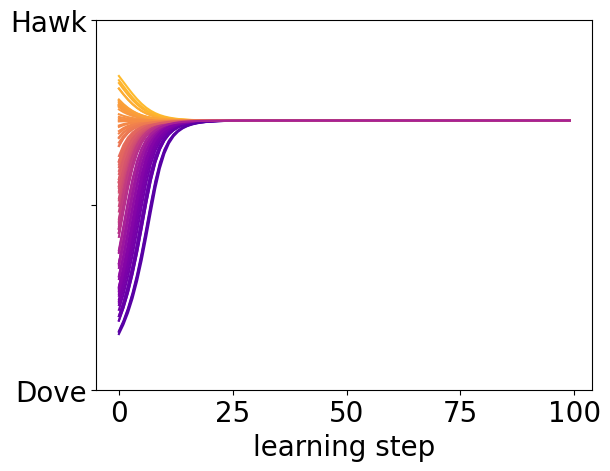

In [91]:
plot_2d_experiments_self_play(action_1,
                   action_2,
                   all_hist,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} self-play agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

In [52]:
# Self-Play from random

game = "hd"
game_str = "Hawk Dove"
lola_ratio = 0.0
action_1 = "Hawk"
action_2 = "Dove"

device = "cuda:0"
nb_agent_pairs = 1
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

final_policies_list = []
all_hist = []

for seed in range(1000):
    res = experiment(sim_fn,
                    game,
                    nb_agent_pairs=nb_agent_pairs,
                    learning_rate=learning_rate,
                    lola_learning_rate=lola_learning_rate,
                    nb_iterations=nb_iterations,
                    lola_ratio=lola_ratio,
                    device=device,
                    random_init=True,
                    seed=seed,
                    repeatitions=repeatitions,
                    timeout=timeout,
                    self_play=True)
    final_policies_list.append(res[-1])
    all_hist.append(res[:100])
# manual count:
count_hh = 0
count_ss = 0
count_sh = 0
count_other = 0
final_policies = []
for final_params in final_policies_list:
    stags = 0
    hares = 0
    for params in final_params:
        policy = torch.nn.functional.softmax(params, dim=0)
        final_policies.append(policy)
        if policy[0] > 0.99:
            stags += 1
        elif policy[1] > 0.99:
            hares += 1
    nb_agents = final_params.shape[0]
    if stags == nb_agents:
        count_ss += 1
    elif hares == nb_agents:
        count_hh += 1
    elif stags == hares == 1:
        count_sh += 1
    else:
        count_other +=1

count_total = count_hh + count_ss + count_sh + count_other

title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)"
print(title)
print(f"SS: {count_ss / count_total}, HH: {count_hh / count_total}, SH: {count_sh / count_total}, other: {count_other / count_total} (total: {count_total})")
print(final_policies)

Hawk Dove - 2 agents (0% LOLA)
SS: 0.0, HH: 0.0, SH: 0.0, other: 1.0 (total: 1000)
[tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor([0.5000, 0.5000]), tensor

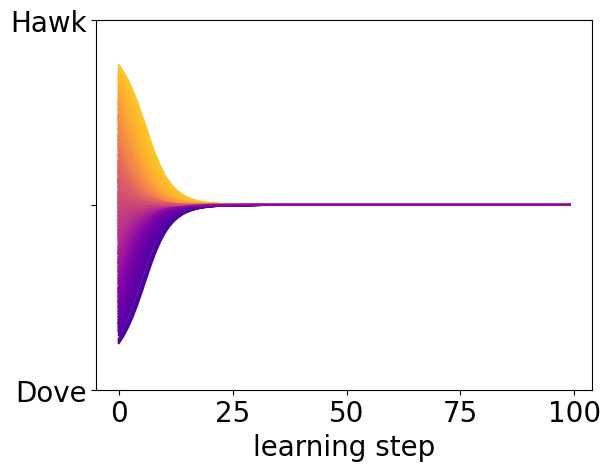

In [53]:
plot_2d_experiments_self_play(action_1,
                   action_2,
                   all_hist,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} self-play agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

In [54]:
# Random play from random (LOLA)

game = "hd"
game_str = "Hawk Dove"
lola_ratio = 1.0
action_1 = "Hawk"
action_2 = "Dove"

device = "cuda:0"
nb_agent_pairs = 1
learning_rate = 0.1 #1.0
lola_learning_rate = 0.1 #1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

final_policies_list = []
all_hist = []

for seed in range(100):
    res = experiment(sim_fn,
                    game,
                    nb_agent_pairs=nb_agent_pairs,
                    learning_rate=learning_rate,
                    lola_learning_rate=lola_learning_rate,
                    nb_iterations=nb_iterations,
                    lola_ratio=lola_ratio,
                    device=device,
                    random_init=True,
                    seed=seed,
                    repeatitions=repeatitions,
                    timeout=timeout,
                    self_play=False)
    final_policies_list.append(res[-1])
    all_hist.append(res)
# manual count:
count_hh = 0
count_ss = 0
count_sh = 0
count_other = 0
final_policies = []
for final_params in final_policies_list:
    stags = 0
    hares = 0
    for params in final_params:
        policy = torch.nn.functional.softmax(params, dim=0)
        final_policies.append(policy)
        if policy[0] > 0.99:
            stags += 1
        elif policy[1] > 0.99:
            hares += 1
    nb_agents = final_params.shape[0]
    if stags == nb_agents:
        count_ss += 1
    elif hares == nb_agents:
        count_hh += 1
    elif stags == hares == 1:
        count_sh += 1
    else:
        count_other +=1

count_total = count_hh + count_ss + count_sh + count_other

title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)"
print(title)
print(f"SS: {count_ss / count_total}, HH: {count_hh / count_total}, SH: {count_sh / count_total}, other: {count_other / count_total} (total: {count_total})")
print(final_policies)

Hawk Dove - 2 agents (100% LOLA)
SS: 0.0, HH: 0.0, SH: 1.0, other: 0.0 (total: 100)
[tensor([0.9945, 0.0055]), tensor([0.0054, 0.9946]), tensor([0.9945, 0.0055]), tensor([0.0057, 0.9943]), tensor([0.0062, 0.9938]), tensor([0.9938, 0.0062]), tensor([0.9944, 0.0056]), tensor([0.0056, 0.9944]), tensor([0.0053, 0.9947]), tensor([0.9946, 0.0054]), tensor([0.0059, 0.9941]), tensor([0.9941, 0.0059]), tensor([0.0054, 0.9946]), tensor([0.9946, 0.0054]), tensor([0.9940, 0.0060]), tensor([0.0060, 0.9940]), tensor([0.9943, 0.0057]), tensor([0.0057, 0.9943]), tensor([0.9945, 0.0055]), tensor([0.0055, 0.9945]), tensor([0.9938, 0.0062]), tensor([0.0063, 0.9937]), tensor([0.0062, 0.9938]), tensor([0.9938, 0.0062]), tensor([0.9944, 0.0056]), tensor([0.0056, 0.9944]), tensor([0.0055, 0.9945]), tensor([0.9945, 0.0055]), tensor([0.0057, 0.9943]), tensor([0.9943, 0.0057]), tensor([0.0067, 0.9933]), tensor([0.9933, 0.0067]), tensor([0.0057, 0.9943]), tensor([0.9944, 0.0056]), tensor([0.0059, 0.9941]), tenso

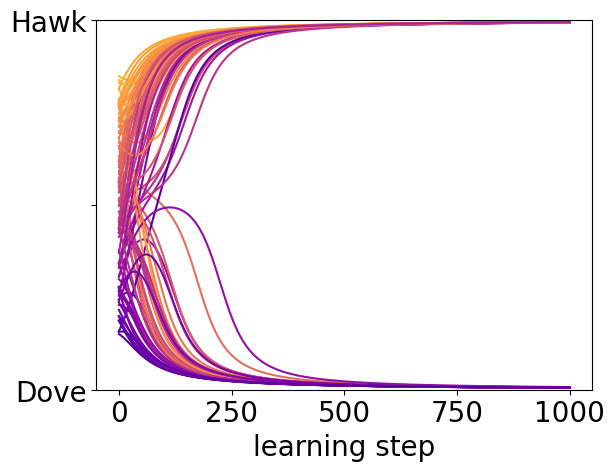

In [55]:
plot_2d_experiments_self_play(action_1,
                   action_2,
                   all_hist,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} non-self-play agents ({int((lola_ratio) * 100)}% LOLA)",
                   dpi=100)

## Rock paper scissor

In [56]:
def plot_3d_experiment_2d(action_1, action_2, action_3, hist, nb_2d_bins=100, title=None, initial_idx=0, nb_steps=1, arrow_width=0.001, dpi=200, show=True):
    with torch.no_grad():
        mat_3d_to_2d = torch.Tensor([[0, 1, 1/2],
                                     [0, 0, np.sqrt(3)/2]])
        
        # Create canvas
        fig = plt.figure(dpi=dpi)
        ax = fig.add_subplot()

        # Constants
        v11 = torch.tensor([1, 0, 0], dtype=torch.float)
        v12 = torch.tensor([0, 1, 0], dtype=torch.float)
        v13 = torch.tensor([0, 0, 1], dtype=torch.float)

        v21 = torch.tensor([1, 1, 0], dtype=torch.float)
        v22 = torch.tensor([1, 0, 1], dtype=torch.float)
        v23 = torch.tensor([0, 1, 1], dtype=torch.float)
        
        # compute 2D projection
        start_population = torch.nn.functional.softmax(hist[initial_idx], dim=1)
        assert start_population.shape[1] == 3  # 3D
        end_population = torch.nn.functional.softmax(hist[initial_idx + nb_steps], dim=1)
        start_population_2d = torch.einsum("ij,bj->bi", mat_3d_to_2d, start_population)
        end_population_2d = torch.einsum("ij,bj->bi", mat_3d_to_2d, end_population)

        # compute triangle members
        # test_sum = 0
        triangles = []
        nb_triangles = 0
        incr = 1.0 / nb_2d_bins
        for i in range(nb_2d_bins):
            for j in range(nb_2d_bins):
                for k in range(nb_2d_bins):
                    # skip undefined triangles
                    sum_ijk = i + j + k
                    diff = nb_2d_bins - sum_ijk  # diff is either 1 or 2
                    if diff not in [1, 2]:
                        continue

                    nb_triangles += 1

                    idx = (start_population[:, 0] >= i * incr) & (start_population[:, 0] <= (i + 1) * incr) & \
                          (start_population[:, 1] >= j * incr) & (start_population[:, 1] <= (j + 1) * incr) & \
                          (start_population[:, 2] >= k * incr) & (start_population[:, 2] <= (k + 1) * incr)

                    if torch.any(idx):
                        # test_sum += torch.sum(idx)
                        v = torch.tensor([i, j, k], dtype=torch.float)
                        if diff == 1:
                            # upward triangle: vertices are 1 coordinate away from i,j,k
                            v1 = v + v11
                            v2 = v + v12
                            v3 = v + v13
                            v = (v1 + v2 + v3) / (3.0 * nb_2d_bins)
                        elif diff == 2:
                            # downward triangle: vertices are 2 coordinates away from i,j,k
                            v1 = v + v21
                            v2 = v + v22
                            v3 = v + v23
                            v = (v1 + v2 + v3) / (3.0 * nb_2d_bins)
                        else:
                            raise RuntimeError(f"diff: {diff}")
                        
                        # print(idx.shape)
                        mean_vector_2d = torch.mean(end_population_2d[idx] - start_population_2d[idx], dim=0).numpy()
                        centroid_2d = torch.einsum("ij,j->i", mat_3d_to_2d, v).numpy()

                        v1 = torch.einsum("ij,j->i", mat_3d_to_2d, v1/nb_2d_bins).numpy()
                        v2 = torch.einsum("ij,j->i", mat_3d_to_2d, v2/nb_2d_bins).numpy()
                        v3 = torch.einsum("ij,j->i", mat_3d_to_2d, v3/nb_2d_bins).numpy()
                        nb_agents = len(torch.nonzero(idx))
                        triangles.append((v1, v2, v3, centroid_2d, mean_vector_2d, nb_agents))

        # draw shades
        population_size = len(start_population)

        for triangle in triangles:
            v1, v2, v3, centroid_2d, mean_vector_2d, nb_agents = triangle
            spatial_proportion = nb_triangles * nb_agents / population_size
            spatial_proportion = spatial_proportion / 20
            # print(spatial_proportion, nb_triangles, nb_agents, population_size)
            shade = min(1, spatial_proportion)
            c = (1 - shade, 1 - shade, 1)
            ax.fill((v1[0], v2[0], v3[0]), (v1[1], v2[1], v3[1]), c=c)

        # draw arrows
        for triangle in triangles:
            v1, v2, v3, centroid_2d, mean_vector_2d, nb_agents = triangle
            alpha = min(1, (nb_agents/10) ** 2)
            # alpha = 1
            color = (1, 0, 0, alpha)
            ax.quiver(centroid_2d[0], centroid_2d[1], mean_vector_2d[0], mean_vector_2d[1], angles='xy', scale_units='xy', width=arrow_width, scale=1, color=color)

        margin = 0.02
        ax.set_aspect('equal', 'box')
        c = "lightgrey"
        linewidth = 1
        plt.plot([0, 1], [0, 0], c=c, linewidth=linewidth)
        plt.plot([0, 1/2], [0, np.sqrt(3)/2], c=c, linewidth=linewidth)
        plt.plot([1/2, 1], [np.sqrt(3)/2, 0], c=c, linewidth=linewidth)
        plt.axis('off')

        down_offset = 0.07
        up_offset = 0.02
        fontsize = 20.0
        plt.text(0, 0 - down_offset, action_1[0], fontsize=fontsize, horizontalalignment="center", color="black")
        plt.text(1, 0 - down_offset, action_2[0], fontsize=fontsize, horizontalalignment="center", color="black")
        plt.text(1/2, np.sqrt(3)/2 + up_offset, action_3[0], fontsize=fontsize, horizontalalignment="center", color="black")
        # if title:
        #     plt.title(title)
        plt.savefig(SAV_DIR / f"{title}.png", bbox_inches='tight')
        if show:
            plt.show()

In [57]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt


def add_polygon(ax, triangle_2d, z_base, z_end, alpha):

    vfaces = np.array(
        [
            [
                [triangle_2d[0][0], triangle_2d[0][1], z_base],
                [triangle_2d[1][0], triangle_2d[1][1], z_base],
                [triangle_2d[1][0], triangle_2d[1][1], z_end],
                [triangle_2d[0][0], triangle_2d[0][1], z_end],
                [triangle_2d[0][0], triangle_2d[0][1], z_base]
            ],
            [
                [triangle_2d[1][0], triangle_2d[1][1], z_base],
                [triangle_2d[2][0], triangle_2d[2][1], z_base],
                [triangle_2d[2][0], triangle_2d[2][1], z_end],
                [triangle_2d[1][0], triangle_2d[1][1], z_end],
                [triangle_2d[1][0], triangle_2d[1][1], z_base]
            ],
            [
                [triangle_2d[2][0], triangle_2d[2][1], z_base],
                [triangle_2d[0][0], triangle_2d[0][1], z_base],
                [triangle_2d[0][0], triangle_2d[0][1], z_end],
                [triangle_2d[2][0], triangle_2d[2][1], z_end],
                [triangle_2d[2][0], triangle_2d[2][1], z_base]
            ]
        ])

    hfaces = np.array(
        [
            [
                [triangle_2d[0][0], triangle_2d[0][1], z_base],
                [triangle_2d[1][0], triangle_2d[1][1], z_base],
                [triangle_2d[2][0], triangle_2d[2][1], z_base],
                [triangle_2d[0][0], triangle_2d[0][1], z_base]
            ],
            [
                [triangle_2d[0][0], triangle_2d[0][1], z_end],
                [triangle_2d[1][0], triangle_2d[1][1], z_end],
                [triangle_2d[2][0], triangle_2d[2][1], z_end],
                [triangle_2d[0][0], triangle_2d[0][1], z_end]
            ]
        ])
    
    c = (0, 0, 1, alpha)

    vpolygon = Poly3DCollection(vfaces)
    hpolygon = Poly3DCollection(hfaces)
    hpolygon.set_color(c)
    hpolygon.set_edgecolor((0, 0, 0, 0))
    vpolygon.set_color(c)
    vpolygon.set_edgecolor((0, 0, 0, 0))
    ax.add_collection3d(hpolygon)
    ax.add_collection3d(vpolygon)


def plot_3d_experiment_3d(action_1, action_2, action_3, hist, nb_2d_bins=100, title=None, steps=[0, 10, 20], azim=None, dpi=200, bin_above=2):
    with torch.no_grad():
        mat_3d_to_2d = torch.Tensor([[0, 1, 1/2],
                                     [0, 0, np.sqrt(3)/2]])
        
        # Create canvas
        fig = plt.figure(dpi=dpi)
        ax = Axes3D(fig, auto_add_to_figure=False)
        ax.view_init(azim=azim) 
        fig.add_axes(ax)

        # Constants
        v11 = torch.tensor([1, 0, 0], dtype=torch.float)
        v12 = torch.tensor([0, 1, 0], dtype=torch.float)
        v13 = torch.tensor([0, 0, 1], dtype=torch.float)

        v21 = torch.tensor([1, 1, 0], dtype=torch.float)
        v22 = torch.tensor([1, 0, 1], dtype=torch.float)
        v23 = torch.tensor([0, 1, 1], dtype=torch.float)

        for i in range(len(steps) - 1):
            initial_idx = steps[i]
            end_idx = steps[i+1]
        
            # compute 2D projection
            start_population = torch.nn.functional.softmax(hist[initial_idx], dim=1)
            assert start_population.shape[1] == 3  # 3D
            end_population = torch.nn.functional.softmax(hist[end_idx], dim=1)
            start_population_2d = torch.einsum("ij,bj->bi", mat_3d_to_2d, start_population)
            end_population_2d = torch.einsum("ij,bj->bi", mat_3d_to_2d, end_population)

            # compute triangle members
            triangles = []
            nb_triangles = 0
            incr = 1.0 / nb_2d_bins
            for i in range(nb_2d_bins):
                for j in range(nb_2d_bins):
                    for k in range(nb_2d_bins):
                        # skip undefined triangles
                        sum_ijk = i + j + k
                        diff = nb_2d_bins - sum_ijk  # diff is either 1 or 2
                        if diff not in [1, 2]:
                            continue

                        nb_triangles += 1

                        idx = (start_population[:, 0] >= i * incr) & (start_population[:, 0] <= (i + 1) * incr) & \
                            (start_population[:, 1] >= j * incr) & (start_population[:, 1] <= (j + 1) * incr) & \
                            (start_population[:, 2] >= k * incr) & (start_population[:, 2] <= (k + 1) * incr)

                        if torch.any(idx):
                            v = torch.tensor([i, j, k], dtype=torch.float)
                            if diff == 1:
                                # upward triangle: vertices are 1 coordinate away from i,j,k
                                v1 = v + v11
                                v2 = v + v12
                                v3 = v + v13
                                v = (v1 + v2 + v3) / (3.0 * nb_2d_bins)
                            elif diff == 2:
                                # downward triangle: vertices are 2 coordinates away from i,j,k
                                v1 = v + v21
                                v2 = v + v22
                                v3 = v + v23
                                v = (v1 + v2 + v3) / (3.0 * nb_2d_bins)
                            else:
                                raise RuntimeError(f"diff: {diff}")
                            
                            mean_vector_2d = torch.mean(end_population_2d[idx] - start_population_2d[idx], dim=0).numpy()

                            v1 = torch.einsum("ij,j->i", mat_3d_to_2d, v1/nb_2d_bins).numpy()
                            v2 = torch.einsum("ij,j->i", mat_3d_to_2d, v2/nb_2d_bins).numpy()
                            v3 = torch.einsum("ij,j->i", mat_3d_to_2d, v3/nb_2d_bins).numpy()
                            nb_agents = len(torch.nonzero(idx))
                            triangles.append((v1, v2, v3, None, mean_vector_2d, nb_agents))

            # draw shades
            population_size = len(start_population)

            for triangle in triangles:
                v1, v2, v3, _, mean_vector_2d, nb_agents = triangle
                spatial_proportion = nb_triangles * nb_agents / population_size
                spatial_proportion = spatial_proportion / 100
                shade = min(1, spatial_proportion)

                add_polygon(ax, [v1, v2, v3], initial_idx, end_idx, alpha=shade)

        c = "lightgrey"
        linewidth = 1
        plt.plot([0, 1], [0, 0], c=c, linewidth=linewidth)
        plt.plot([0, 1/2], [0, np.sqrt(3)/2], c=c, linewidth=linewidth)
        plt.plot([1/2, 1], [np.sqrt(3)/2, 0], c=c, linewidth=linewidth)

        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_zlabel("\nevolution step\n")

        up_offset = 0
        fontsize = 10
        ax.text(0, 0, 0 + up_offset, action_1, horizontalalignment="center", fontsize=fontsize)
        ax.text(1, 0, 0 + up_offset, action_2, horizontalalignment="center", fontsize=fontsize)
        ax.text(1/2, np.sqrt(3)/2, 0 + up_offset, action_3, horizontalalignment="center", fontsize=fontsize)

        # if title:
        #     plt.title(title)
        ax.set_box_aspect(aspect=None, zoom=0.8)
        plt.savefig(SAV_DIR / f"{title}.png", bbox_inches='tight')
        plt.show()

In [58]:
def plot_3d_experiment_3d_lines(action_1, action_2, action_3, hist, title=None, azim=None, dpi=200):
    with torch.no_grad():
        mat_3d_to_2d = torch.Tensor([[0, 1, 1/2],
                                     [0, 0, np.sqrt(3)/2]])
        
        # Create canvas
        fig = plt.figure(dpi=dpi)
        ax = Axes3D(fig, auto_add_to_figure=False)
        ax.view_init(azim=azim) 
        fig.add_axes(ax)

        # Constants
        v11 = torch.tensor([1, 0, 0], dtype=torch.float)
        v12 = torch.tensor([0, 1, 0], dtype=torch.float)
        v13 = torch.tensor([0, 0, 1], dtype=torch.float)

        v21 = torch.tensor([1, 1, 0], dtype=torch.float)
        v22 = torch.tensor([1, 0, 1], dtype=torch.float)
        v23 = torch.tensor([0, 1, 1], dtype=torch.float)
        
        c = "lightgrey"
        linewidth = 1
        plt.plot([0, 1], [0, 0], c=c, linewidth=linewidth)
        plt.plot([0, 1/2], [0, np.sqrt(3)/2], c=c, linewidth=linewidth)
        plt.plot([1/2, 1], [np.sqrt(3)/2, 0], c=c, linewidth=linewidth)
        # plt.axis('off')

        ax.xaxis.pane.fill = False
        ax.yaxis.pane.fill = False
        ax.zaxis.pane.fill = False

        ax.xaxis.pane.set_edgecolor('w')
        ax.yaxis.pane.set_edgecolor('w')
        ax.zaxis.pane.set_edgecolor('w')

        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.set_zlabel("\nevolution step\n")

        up_offset = 0
        fontsize = 10
        ax.text(0, 0, 0 + up_offset, action_1, horizontalalignment="center", fontsize=fontsize)
        ax.text(1, 0, 0 + up_offset, action_2, horizontalalignment="center", fontsize=fontsize)
        ax.text(1/2, np.sqrt(3)/2, 0 + up_offset, action_3, horizontalalignment="center", fontsize=fontsize)

        hist_t = torch.tensor(np.array(hist))
        print(hist_t.shape)

        policies_hist = torch.nn.functional.softmax(hist_t, dim=2)
        policies_hist_2d = torch.einsum("ij,hbj->hbi", mat_3d_to_2d, policies_hist)
        z = np.array(range(len(hist)))
        nb_agents = policies_hist_2d.shape[1]
        for agent in range(nb_agents):
            x = policies_hist_2d[:, agent, 0]
            y = policies_hist_2d[:, agent, 1]
            ax.plot3D(x, y, z)

        if title:
            plt.title(title)
        ax.set_box_aspect(aspect=None, zoom=0.8)
        plt.savefig(SAV_DIR / f"{title}.png", bbox_inches='tight')
        plt.show()

In [59]:
game = "rps"
game_str = "Rock Paper Scissors"
lola_ratio = 0.0
action_1 = "R"
action_2 = "P"
action_3 = "S"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 10000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

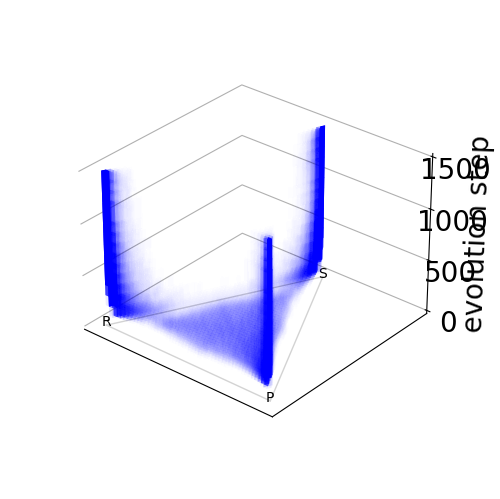

In [60]:
initial_idx = 0
# steps = [0,10,20,30,40,50,60,70,80,90,100]
steps = [0,100,200,300,400,500,600,700,800,900,1000,1200,1300,1400,1500]

plot_3d_experiment_3d(action_1,
                      action_2,
                      action_3,
                      res,
                      nb_2d_bins=50,
                      title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                      steps=steps,
                      azim=-50,
                      dpi=100)

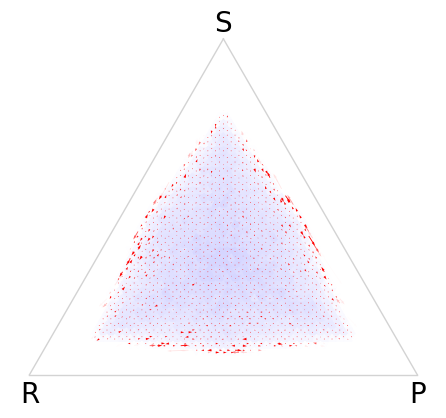

In [62]:
initial_idx = 0

plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

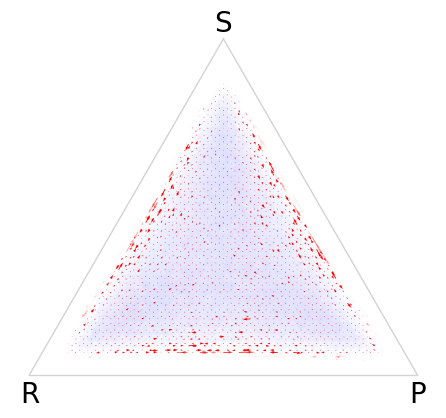

In [63]:
initial_idx = 10
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

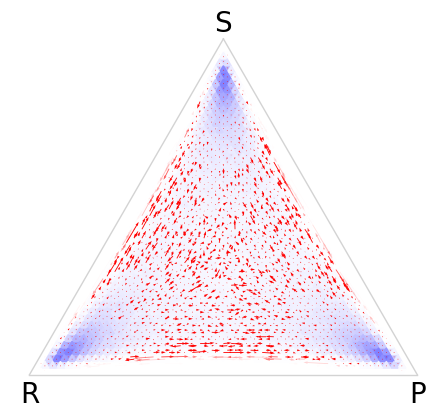

In [64]:
initial_idx = 50
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

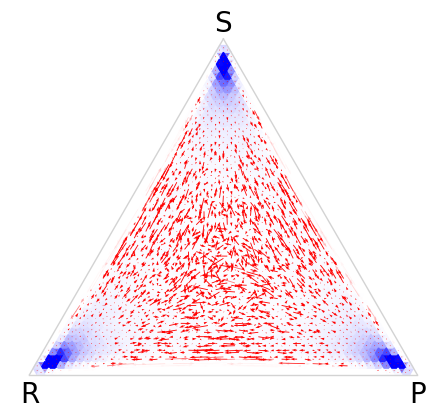

In [65]:
initial_idx = 100
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

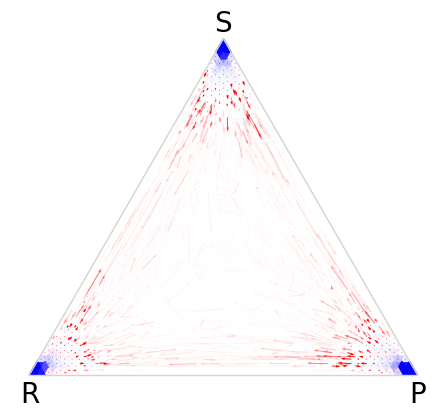

In [66]:
initial_idx = 1000
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

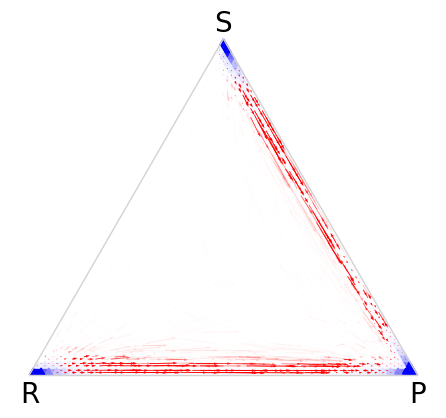

In [67]:
initial_idx = 4400
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

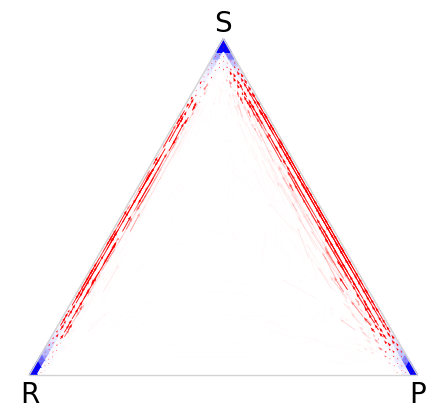

In [68]:
initial_idx = 4800
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

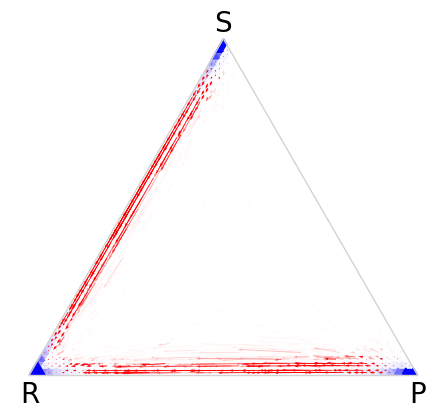

In [69]:
initial_idx = 5100
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

In [70]:
game = "rps"
game_str = "Rock Paper Scissors"
lola_ratio = 1.0
action_1 = "R"
action_2 = "P"
action_3 = "S"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

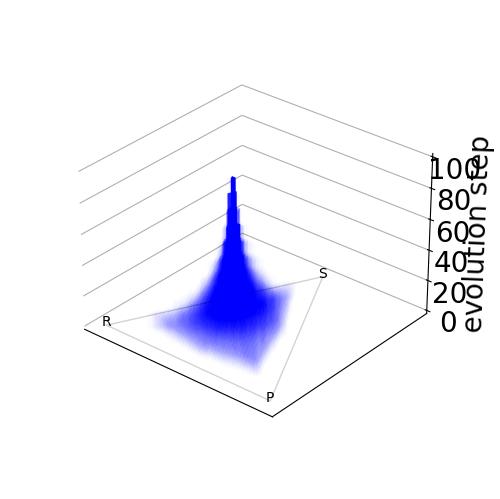

In [71]:
initial_idx = 0
steps = [0,10,20,30,40,50,60,70,80,90,100]
# steps = [0,100,200,300,400,500,600,700,800,900,999]

plot_3d_experiment_3d(action_1,
                      action_2,
                      action_3,
                      res,
                      nb_2d_bins=50,
                      title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                      steps=steps,
                      azim=-50,
                      dpi=100)

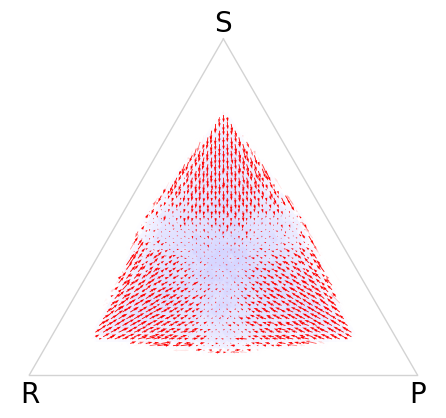

In [72]:
initial_idx = 0
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

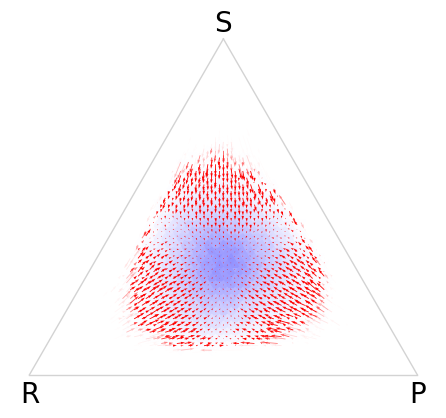

In [73]:
initial_idx = 10
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

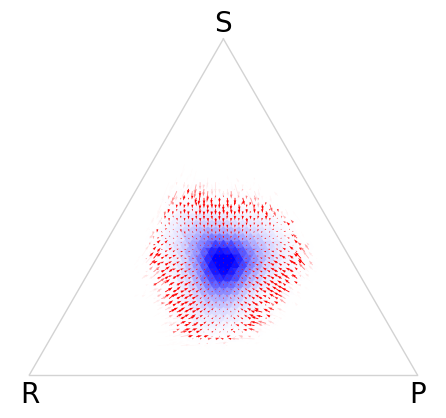

In [74]:
initial_idx = 20
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

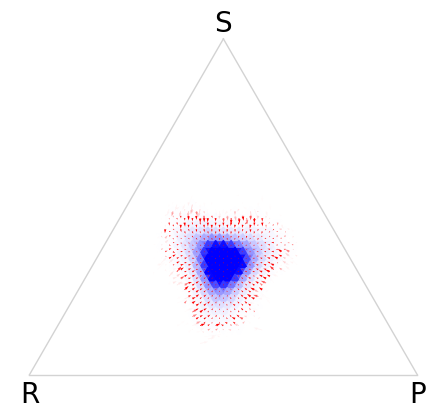

In [75]:
initial_idx = 30
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

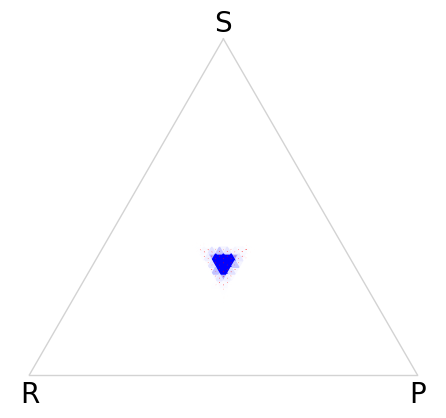

In [76]:
initial_idx = 60
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

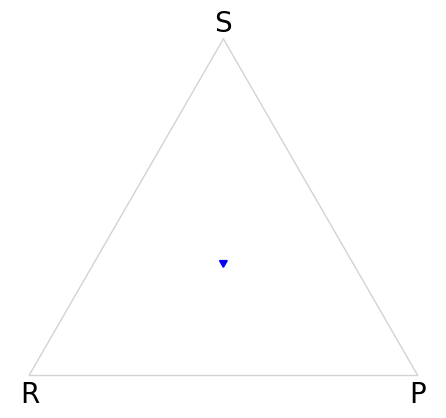

In [77]:
initial_idx = 100
plot_3d_experiment_2d(action_1,
                   action_2,
                   action_3,
                   res,
                   nb_2d_bins=50,
                   title=f"{game_str} - {int(nb_agent_pairs * 2)} agents - evolution step {initial_idx} ({int((lola_ratio) * 100)}% LOLA)",
                   initial_idx=initial_idx,
                   nb_steps=1,
                   arrow_width=0.002,
                   dpi=100)

In [78]:
game = "rps"
game_str = "Rock Paper Scissors"
lola_ratio = 0.2
action_1 = "R"
action_2 = "P"
action_3 = "S"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 1001

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

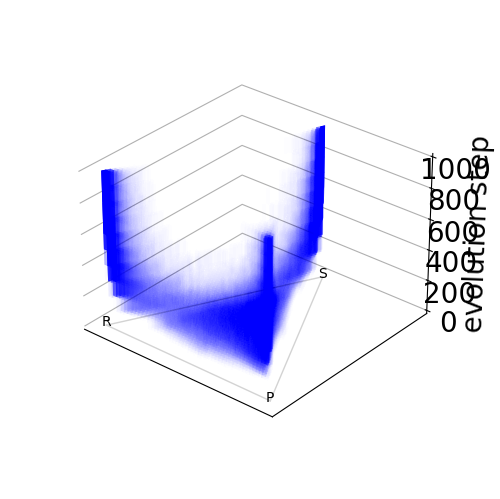

In [79]:
initial_idx = 0
steps = [0,100,200,300,400,500,600,700,800,900,1000]

plot_3d_experiment_3d(action_1,
                      action_2,
                      action_3,
                      res,
                      nb_2d_bins=50,
                      title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                      steps=steps,
                      azim=-50,
                      dpi=100)

In [95]:
game = "rps"
game_str = "Rock Paper Scissors"
lola_ratio = 0.3
action_1 = "R"
action_2 = "P"
action_3 = "S"

device = "cuda:0"
nb_agent_pairs = 100000
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 10001

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

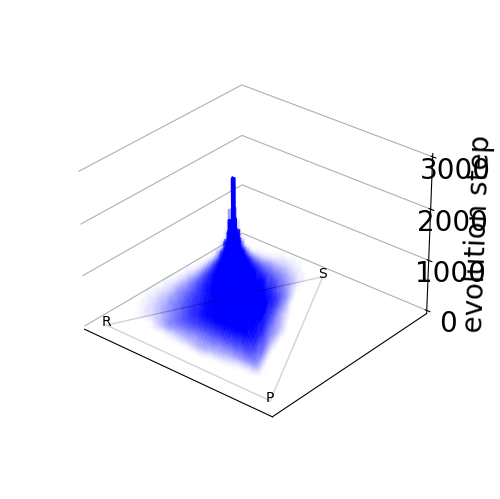

In [96]:
initial_idx = 0
steps = [0,200,400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600,2800,3000]

plot_3d_experiment_3d(action_1,
                      action_2,
                      action_3,
                      res,
                      nb_2d_bins=50,
                      title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                      steps=steps,
                      azim=-50,
                      dpi=100)

# RPS additional experiments

In [82]:
# 2 random agents

game = "rps"
game_str = "Rock Paper Scissors"
lola_ratio = 1.0
action_1 = "R"
action_2 = "P"
action_3 = "S"

device = "cuda:0"
nb_agent_pairs = 1
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 10000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

torch.Size([100, 2, 3])


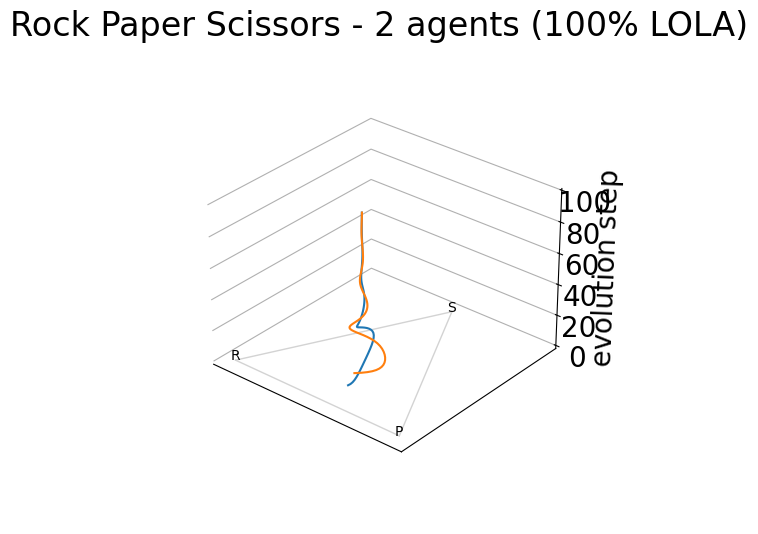

In [83]:
initial_idx = 0

plot_3d_experiment_3d_lines(action_1,
                            action_2,
                            action_3,
                            res[:100],
                            title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                            azim=-50,
                            dpi=100)

In [84]:
# 2 random agents

game = "rps"
game_str = "Rock Paper Scissors"
lola_ratio = 0.0
action_1 = "R"
action_2 = "P"
action_3 = "S"

device = "cuda:0"
nb_agent_pairs = 1
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 10000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout)

torch.Size([100, 2, 3])


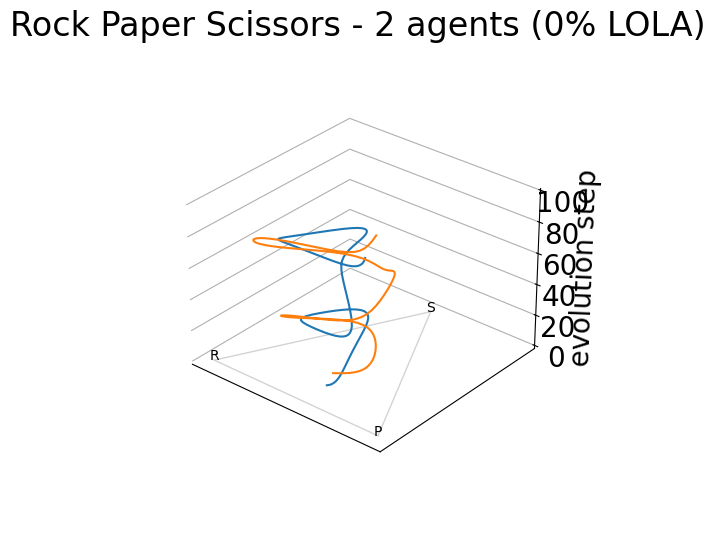

In [85]:
initial_idx = 0

plot_3d_experiment_3d_lines(action_1,
                            action_2,
                            action_3,
                            res[:100],
                            title=f"{game_str} - {int(nb_agent_pairs * 2)} agents ({int((lola_ratio) * 100)}% LOLA)",
                            azim=-50,
                            dpi=100)

In [86]:
# 2 self-play agents

game = "rps"
game_str = "Rock Paper Scissors"
lola_ratio = 1.0
action_1 = "R"
action_2 = "P"
action_3 = "S"

device = "cuda:0"
nb_agent_pairs = 1
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 0
repeatitions = 1
timeout = 100.0
nb_iterations = 10000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout,
                 self_play=True)

torch.Size([100, 2, 3])


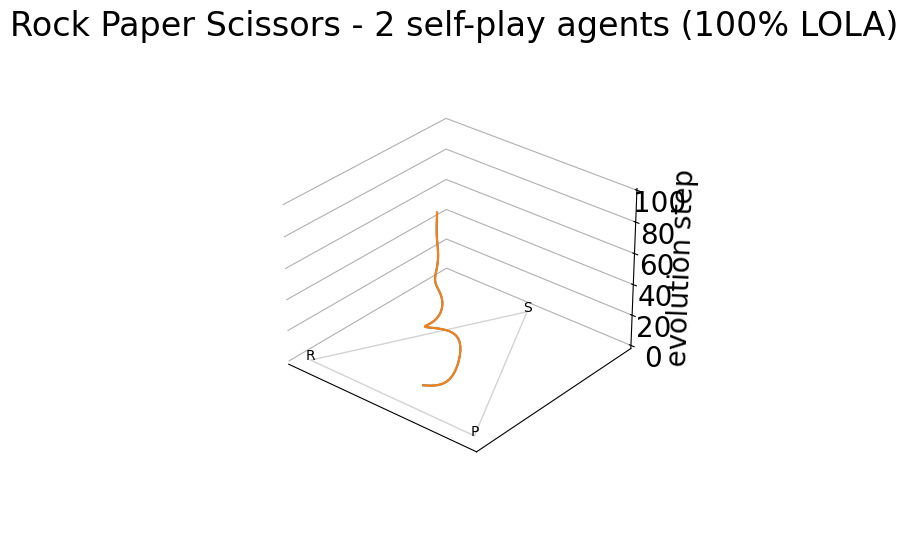

In [87]:
plot_3d_experiment_3d_lines(action_1,
                            action_2,
                            action_3,
                            res[:100],
                            title=f"{game_str} - {int(nb_agent_pairs * 2)} self-play agents ({int((lola_ratio) * 100)}% LOLA)",
                            azim=-50,
                            dpi=100)

In [88]:
# 2 self-play agents

game = "rps"
game_str = "Rock Paper Scissors"
lola_ratio = 0.0
action_1 = "R"
action_2 = "P"
action_3 = "S"

device = "cuda:0"
nb_agent_pairs = 1
learning_rate = 1.0
lola_learning_rate = 1.0
sim_fn = simulation
seed = 8
repeatitions = 1
timeout = 100.0
nb_iterations = 10000

res = experiment(sim_fn,
                 game,
                 nb_agent_pairs=nb_agent_pairs,
                 learning_rate=learning_rate,
                 lola_learning_rate=lola_learning_rate,
                 nb_iterations=nb_iterations,
                 lola_ratio=lola_ratio,
                 device=device,
                 random_init=True,
                 seed=seed,
                 repeatitions=repeatitions,
                 timeout=timeout,
                 self_play=True)

torch.Size([200, 2, 3])


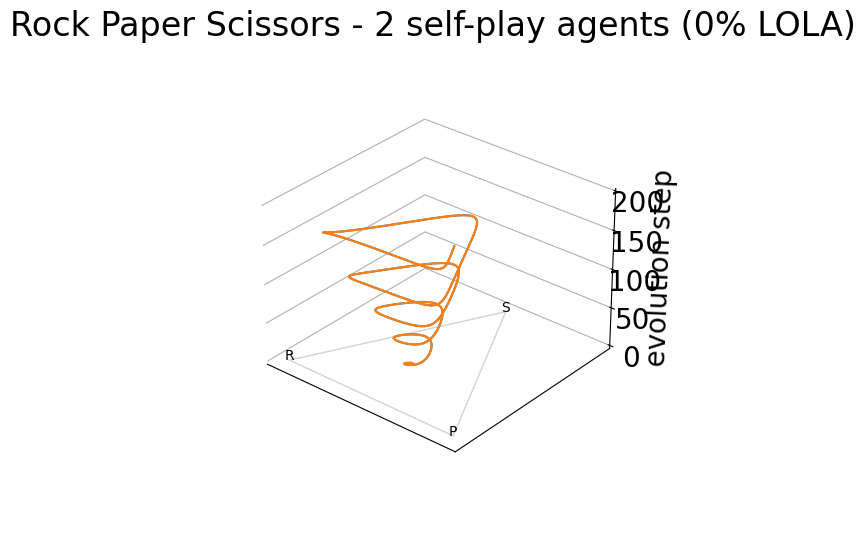

In [89]:
plot_3d_experiment_3d_lines(action_1,
                            action_2,
                            action_3,
                            res[:200],
                            title=f"{game_str} - {int(nb_agent_pairs * 2)} self-play agents ({int((lola_ratio) * 100)}% LOLA)",
                            azim=-50,
                            dpi=100)